# Regularized collaborative filtering with pytorch

Start again with a momentum base to gradient descent that uses a randomly selected validation set each iteration to measure validation error. Add L2 regularization to the process. Start without bias vector first.

## Support code

In [1]:
import math
import torch
dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def RF_valid(df, movie_embeddings, user_embeddings):
    X = df[['movieId','userId']]
    y = df['rating']
    X_emb = np.concatenate([movie_embeddings[X['movieId']],user_embeddings[X['userId']]], axis=1)

    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    rf.fit(X_emb, y)
    print(f"OOB R^2 {rf.oob_score_:.3f}")
    print(f"Train R^2 {rf.score(X_emb, y):.3f}")

In [180]:
import pandas as pd
import re

def load(n = 10):
    df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
    df_ratings = df_ratings.drop('timestamp', axis=1)
    df_ratings = df_ratings.sample(n=n).reset_index(drop=True)
    # Merge in the title and genres
    df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
    df = df_ratings.merge(df_movies, on='movieId')
    # Strip the "(1999)" dates from the titles
    p = re.compile(r'[()0-9]+$')
    df['title'] = df['title'].map(lambda x: p.sub('', x).strip())
    return df

def compress_cats(df, colname):
    df[colname] = df[colname].astype('category').cat.as_ordered()
    df[colname] = df[colname].cat.codes # encode 0..n-1  NB: Different than I usually do (1..n)!!!!
    df[colname] = df[colname].astype(int)
    
def normal_transform(x, mean=0.0, std=0.01):
    "Convert x to have mean and std"
    return x*std + mean

def randn(n1, n2, device, dtype, mean=0.0, std=0.01, requires_grad=False):
    x = torch.randn(n1, n2, device=device, dtype=dtype)
    x = normal_transform(x, mean=mean, std=std)
    x.requires_grad=requires_grad
    return x

In [683]:
def top_movies(df, n=100):
    rating_count = df.groupby('movieId')['rating'].count()
    top_movieIds = rating_count.sort_values(ascending=False).index.values[:n]

    df_top = df[df['movieId'].isin(top_movieIds)][['movieId','title','genres']].drop_duplicates()
    return df_top

In [795]:
import matplotlib.pyplot as plt
def plot_history(history, yrange=(0.0, 5.00), figsize=(3.5,3)):
    plt.figure(figsize=figsize)
    plt.ylabel("Rating (0..5.0) MAE")
    plt.xlabel("Epochs")
    loss = history[:,0]
    valid_loss = history[:,1]
    plt.plot(loss, label='train_loss')
    plt.plot(valid_loss, label='val_loss')
    # plt.xlim(0, 200)
    plt.ylim(*yrange)
    plt.legend(loc='lower right')
    plt.show()

In [794]:
from sklearn.decomposition import PCA

def mcolor(genre):
    if 'Comedy' in genre: return 'green'
    if 'Sci-Fi' in genre: return 'cyan'
    if 'War' in genre: return 'red'
    return 'black'

def plot_comedy_drama_embeddings(df, movie_embeddings, n=1000, xrange=(-1,1), yrange=(-1,1)):
    df_movies = top_movies(df, n)
#     df_movies = df_movies[(df_movies['genres']=='Comedy')|(df_movies['genres']=='Drama')]
    movie_embeddings = movie_embeddings[df_movies['movieId'].values]
    
    plt.figure(figsize=(5,5))
    movieIds = df_movies['movieId'].values
    genres = df_movies['genres'].values
    titles = df_movies['title'].values
    pca = PCA(n_components=2)
    vecs2D = pca.fit_transform(movie_embeddings)
    c = [mcolor(genres[i]) for i in range(len(vecs2D))]
    plt.scatter(vecs2D[:,0], vecs2D[:,1], c=c, s=5, alpha=.5)
    plt.xlim(*xrange)
    plt.ylim(*yrange)
    plt.show()
    return df_movies, vecs2D

In [736]:
from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource

output_notebook() # send to notebook not tab

def plot_bokeh_comend_drama_embeddings(df_movies, vecs2D):
    data = dict(
        x=vecs2D[:,0],
        y=vecs2D[:,1],
        title = df_movies['title'],
        genre = df_movies['genres'],
        colors = [mcolor(df_movies['genres'].iloc[i]) for i in range(len(vecs2D))]
    )
    source = ColumnDataSource(data)
    fig = figure(plot_width=500, plot_height=300,
                 title='Movie embeddings projected with PCA',
                 tools='pan,wheel_zoom,zoom_in,box_zoom,reset,hover',
                 x_axis_type=None, y_axis_type=None, min_border=1)
    fig.scatter(x='x', y='y',source=source, fill_alpha=0.7, size=5, fill_color='colors')
    # hover tools,
    hover = fig.select(dict(type=HoverTool))
    hover.tooltips = {'content': '@title (@genre)'}
    show(fig)

Loading BokehJS ...

## Train and track validation error

By randomly selecting validation and training sets at each iteration (epoch), we are moving to stochastic gradient descent (SGD). Previously I only used gradient descent.  Ooops. I can't do that. See below.

The best I have seen is 0.7ish OOB R^2 before SGD.  Adding the `mean=math.sqrt(2.5/nfactors)` seems to have consistently produced about 0.05 R^2 improvement for this SGD. It seemed to help a little bit may be but the effect is not huge using the random forest OOB R^2 validation.

L2 regularization doesn't seem to help that much and with weight decay coefficient very big at all, my SGD send diverges given my rate of learning.   

Initialization does after all seem to make a difference, in both training and validation error.

The interesting thing is that loss and validation loss seem to track on top of each other. Oh! Duh, red flag.  If I keep shuffling and pulling the validation set out dynamically, that means that the training set this round probably leaks into the validation set the next iteration. Ok, so pull out the validation set first and keep both sets fixed during training. That means we are no longer SGD.

Hm...still not satisfied. Add AdaGrad back in. Still didn't work so I guess I'm moving to the new notebook to use higher level torch interface.

In [523]:
df = load(n=20_000)
n = len(df)
nmovies = len(df.groupby('movieId').count())
nusers = len(df.groupby('userId').count())
compress_cats(df, 'movieId') # make IDs 0..nmovies-1
compress_cats(df, 'userId')
df.head(2)

,userId,movieId,rating,title,genres
0,607,4325,3.0,"Mechanic, The",Action|Drama|Thriller
1,120,2133,4.5,"Emperor's New Groove, The",Adventure|Animation|Children|Comedy|Fantasy


In [524]:
avg_rating = np.mean(df['rating'])
avg_rating

3.50735

18000 training and 2000 validation records
Init      MSE training 4.915 valid 4.838
Epoch   0 MSE training 1.572 valid 2.055


/Users/parrt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch  20 MSE training 0.659 valid 1.579
Epoch  40 MSE training 0.622 valid 1.596
Epoch  60 MSE training 0.610 valid 1.605
Epoch  80 MSE training 0.603 valid 1.598
Epoch 100 MSE training 0.599 valid 1.609
Epoch 120 MSE training 0.596 valid 1.605
Epoch 140 MSE training 0.594 valid 1.607
Epoch 160 MSE training 0.592 valid 1.606
Epoch 180 MSE training 0.591 valid 1.600
Epoch 200 MSE training 0.589 valid 1.600
Epoch 220 MSE training 0.589 valid 1.594
Epoch 240 MSE training 0.588 valid 1.592
Epoch 260 MSE training 0.587 valid 1.591
Epoch 280 MSE training 0.586 valid 1.588
Epoch 300 MSE training 0.586 valid 1.587
Epoch 320 MSE training 0.585 valid 1.585
Epoch 340 MSE training 0.585 valid 1.585
Epoch 360 MSE training 0.585 valid 1.584
Epoch 380 MSE training 0.584 valid 1.585
Epoch 400 MSE training 0.584 valid 1.584
Epoch 420 MSE training 0.583 valid 1.585
Epoch 440 MSE training 0.583 valid 1.585
Epoch 460 MSE training 0.583 valid 1.586
Epoch 480 MSE training 0.583 valid 1.586
MAE training 0.3

/Users/parrt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


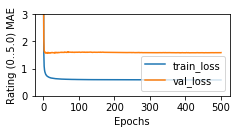

In [793]:
nfactors = 4
n_train = int(n*0.90)
n_valid = n - n_train

U = randn(nusers,  nfactors, device=device, dtype=dtype, requires_grad=True, std=0.1, mean=math.sqrt(avg_rating/nfactors))
M = randn(nmovies, nfactors, device=device, dtype=dtype, requires_grad=True, std=0.1, mean=math.sqrt(avg_rating/nfactors))

data = torch.tensor( df[['userId','movieId','rating']].values )

def mse_loss(U, M, data):
    # data has (user, movie, rating) records
    r_pred = (U[data[:,0].long()] * M[data[:,1].long()]).sum(axis=1)
    r_pred = torch.sigmoid(r_pred) * 5  # limit to 0..5
    diff = r_pred - torch.tensor(data[:,2])
    return torch.mean( diff.pow(2) )

def mae_loss(U, M, data):
    r_pred = (U[data[:,0].long()] * M[data[:,1].long()]).sum(axis=1)
    r_pred = torch.sigmoid(r_pred) * 5  # limit to 0..5
    diff = r_pred - torch.tensor(data[:,2])
    return torch.mean( diff.abs() )

indices = torch.randperm(n)
train_idx = indices[0:n_train]
valid_idx = indices[n_train:]
train, valid = data[train_idx], data[valid_idx] # copying data but could not get columns out of a Subset object
# train, valid = data, data
print(f"{len(train)} training and {len(valid)} validation records")

learning_rate = 1
# momentum = 0.0005
weight_decay = 0.0001
batch_size = 1000
e = 0.0000001  # avoid division by zero when scaling learning rate

history = []

# Start history with what random weights show
with torch.no_grad():
    loss = mse_loss(U, M, train)
    l2_weight_penalty = weight_decay * (U.pow(2).sum() + M.pow(2).sum()) # L2 regularization
    loss += l2_weight_penalty
    valid_loss = mse_loss(U, M, valid)
    valid_loss += l2_weight_penalty
history.append( (loss, valid_loss) )
print(f"Init      MSE training {loss:4.3f} valid {valid_loss:4.3f}")

hU = torch.zeros(size=(nusers, nfactors),  device=device, dtype=dtype)
hM = torch.zeros(size=(nmovies, nfactors), device=device, dtype=dtype)

for t in range(500): # epochs
    permutation = torch.randperm(train.size()[0])
    
    for k in range(0, train.size()[0], batch_size): # mini-batch
        batch_indices = permutation[k:k+batch_size]
        batch_x, batch_y = train[batch_indices], train[batch_indices]

        loss = mse_loss(U, M, batch_x)
        l2_weight_penalty = weight_decay * (U.pow(2).sum() + M.pow(2).sum()) # L2 regularization
        loss += l2_weight_penalty

        loss.backward() # autograd computes U.grad and M.grad

        # Update weights; weights have requires_grad=True but we don't need to track these updates
        with torch.no_grad():
            hU += U.grad * U.grad
            hM += M.grad * M.grad
            U -= learning_rate * U.grad / (torch.sqrt(hU)+e)
            M -= learning_rate * M.grad / (torch.sqrt(hM)+e)

#             U -= (momentum*U + learning_rate * U.grad)
#             M -= (momentum*M + learning_rate * M.grad)
            U.grad.zero_() # reset gradients
            M.grad.zero_()
        
    with torch.no_grad():
        loss = mse_loss(U, M, train)
        l2_weight_penalty = weight_decay * (U.pow(2).sum() + M.pow(2).sum()) # L2 regularization
        loss += l2_weight_penalty
        valid_loss = mse_loss(U, M, valid)
        valid_loss += l2_weight_penalty
    history.append( (loss, valid_loss) )
    if t % 20 == 0:
        print(f"Epoch {t:3d} MSE training {loss:4.3f} valid {valid_loss:4.3f}")

history = torch.tensor(history)

m2 = mae_loss(U, M, train).detach().item()
m2 = mae_loss(U, M, valid).detach().item()
print("MAE training", m1, "validation", m2)
plot_history(history, yrange=(0,3), figsize=(3.5,1.5))

In [ ]:
RF_valid(df, M.detach().cpu(), U.detach().cpu())

Wow. Now I've seen a case where (Stopping at 80 iterations):

```
MAE training 0.3062643175360963 validation 0.727680391928424
```

but got

```
OOB R^2 0.560
Train R^2 0.939
```

Previously when I got OOB R^2 of .62, it was MAE validation error .85. Weird. Clearly there is not a direct correlation between MAE and how well the random forest is able to use the vectors.

Stopping early for regularization seems to get a good validation MAE and loss, by the way.

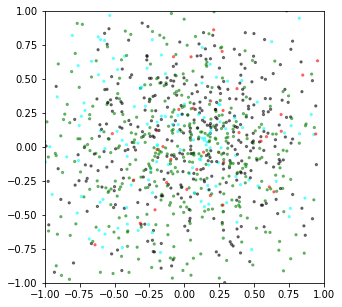

In [778]:
df_movies, vecs2D = plot_comedy_drama_embeddings(df, M.cpu().detach().numpy(), n=1000)#, xrange=(-3,3), yrange=(-3,3))

In [779]:
plot_bokeh_comend_drama_embeddings(df_movies, vecs2D)